In [1]:
import matplotlib.pyplot as plt
import numpy as np

from photutils.detection import DAOStarFinder

import astroalign as aa

from astropy.io import fits
from astropy.stats import mad_std
from astropy.visualization import ZScaleInterval, imshow_norm, ImageNormalize

import aplpy

import os

Carpeta en la que vamos a trabajar

Para cambiar modificar el 'object'

In [2]:
object = 'M34_0001'

path = os.getcwd()
path = os.path.dirname(path)+f'/output/{object}/'
path

'/home/saramunoz/project/panic_camera_analyser/output/M34_0001/'

#### Selección de imagenes de referencia y objetivo

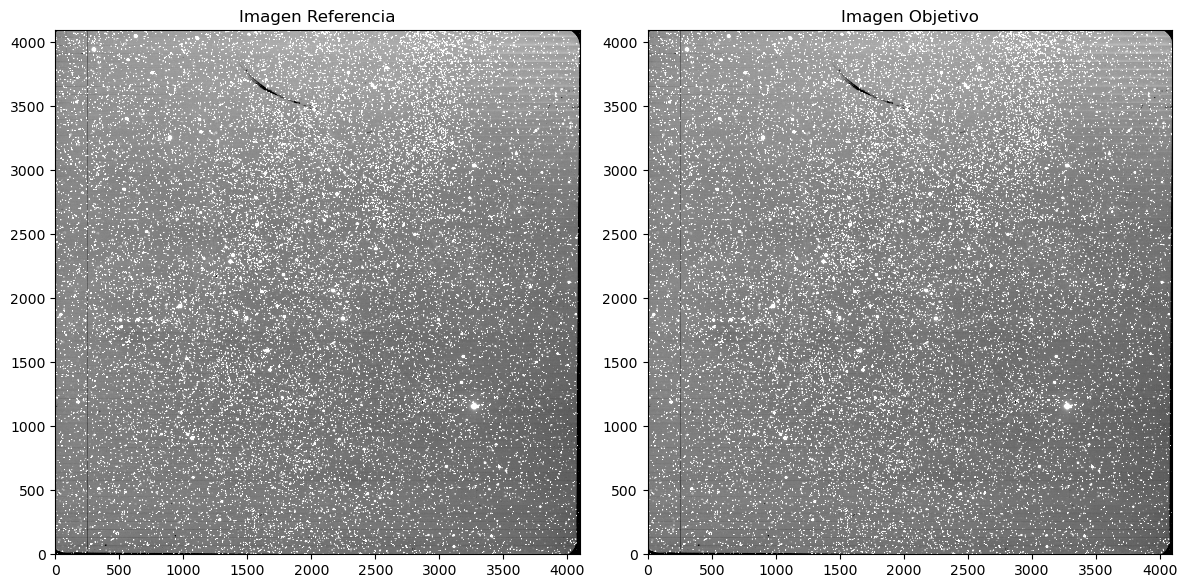

In [24]:
i = 1
j = 2

# read fits to compare
img_ref = fits.getdata(path+f'{object}_slice_{i}.fits')
img_obj = fits.getdata(path+f'{object}_slice_{j}.fits')

# visualization
# norm
def normalization(img):
    intervalo = ZScaleInterval()
    vmin, vmax = intervalo.get_limits(img)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    return norm

# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Imagen Referencia')
plt.imshow(img_ref, cmap='gray',origin='lower', norm=normalization(img_ref))
plt.subplot(1, 2, 2)
plt.title('Imagen Objetivo')
plt.imshow(img_obj, cmap='gray',origin='lower', norm=normalization(img_obj))
plt.tight_layout()
plt.show()


#### Transformación entre las imágenes

**output**
1. Matriz de transformación (transf)
2. Imagen objetivo alineada (img_alin)
3. Pixeles superpuestos al transformar (footprint)

In [25]:
# photutils & astroalign

# finding stars
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*mad_std(img_ref))
star_ref = daofind(img_ref)
star_obj = daofind(img_obj)

# extract coords
coord_ref = np.array(list(zip(star_ref['xcentroid'], star_ref['ycentroid'])))
coord_obj = np.array(list(zip(star_obj['xcentroid'], star_obj['ycentroid'])))

# align by coords
transf, inliers = aa.find_transform(coord_ref, coord_obj)
print('Transformation matrix: \n',transf.params)


Transformation matrix: 
 [[ 1.00002046e+00 -5.15603075e-05 -6.82003160e-02]
 [ 5.15603075e-05  1.00002046e+00 -1.98839389e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [26]:
# astroalign

# transform matrix
#aa.min_triangle_similarity = 0.1  # ajust triangle similarity 
transf, (source_list, target_list) = aa.find_transform(img_ref, img_obj)
print('Transformation matrix: \n',transf.params)

# align
img_alin, footprint = aa.register(img_ref, img_obj)
img_alin2, footprint = aa.apply_transform(transf, img_ref, img_obj)

print((img_alin == img_alin2).all())


# errors
# MSE 
mse = np.mean((img_ref - img_alin) ** 2)
# MAE 
mae = np.mean(np.abs(img_ref - img_alin))
print('\nMSE: ',mse,'\nMAE: ',mae)


Transformation matrix: 
 [[ 1.00003279e+00 -2.52651310e-04  8.60262056e-01]
 [ 2.52651310e-04  1.00003279e+00 -1.05961733e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
True

MSE:  552036.4026007917 
MAE:  63.12720509396385


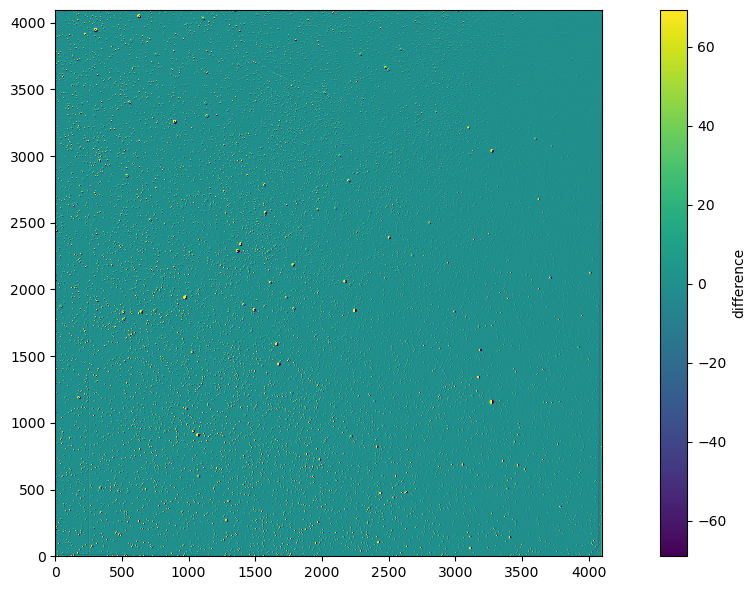

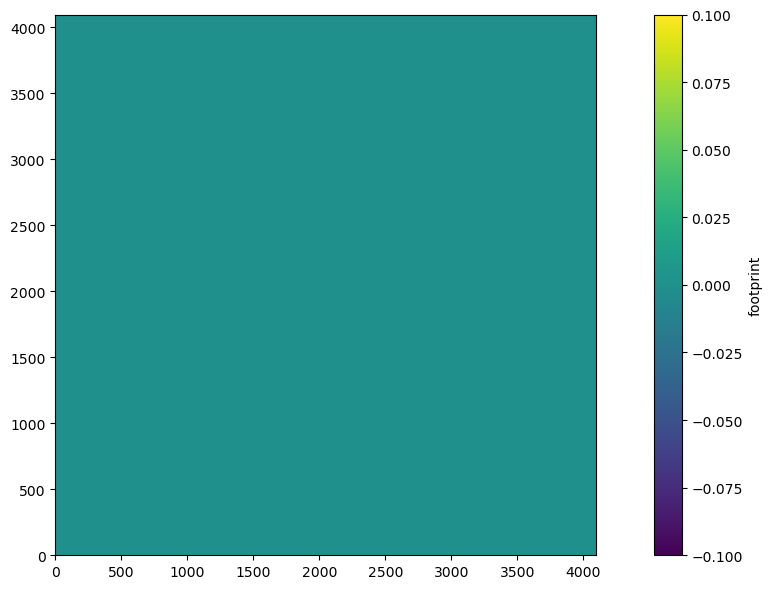

In [21]:
# vis differences
plt.figure(figsize=(12, 6))
plt.imshow(img_alin - img_ref, cmap='viridis',origin='lower', norm=normalization(img_alin - img_ref))
plt.colorbar(label='difference')
plt.tight_layout()
plt.show()

## vis footprint
plt.figure(figsize=(12, 6))
plt.imshow(footprint, cmap='viridis',origin='lower', norm=normalization(footprint))
plt.colorbar(label='footprint')
plt.tight_layout()
plt.show()


##### Imagen alineada final

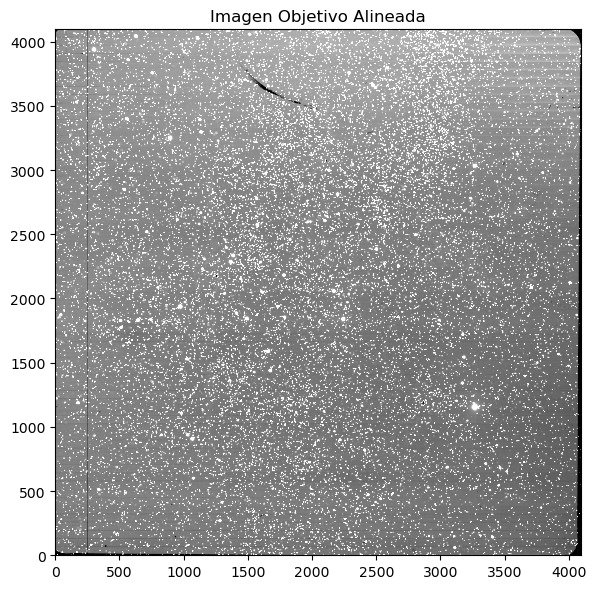

In [68]:
plt.figure(figsize=(12, 6))
plt.title('Imagen Objetivo Alineada')
plt.imshow(img_alin, cmap='gray',origin='lower', norm=normalization(img_alin))
plt.tight_layout()
plt.show()


Set OBSGEO-Y to  -225974.479 from OBSGEO-[LBH].
Set OBSGEO-Z to  3838445.715 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  -225974.479 from OBSGEO-[LBH].
Set OBSGEO-Z to  3838445.715 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.900e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.133e+03 [aplpy.core]


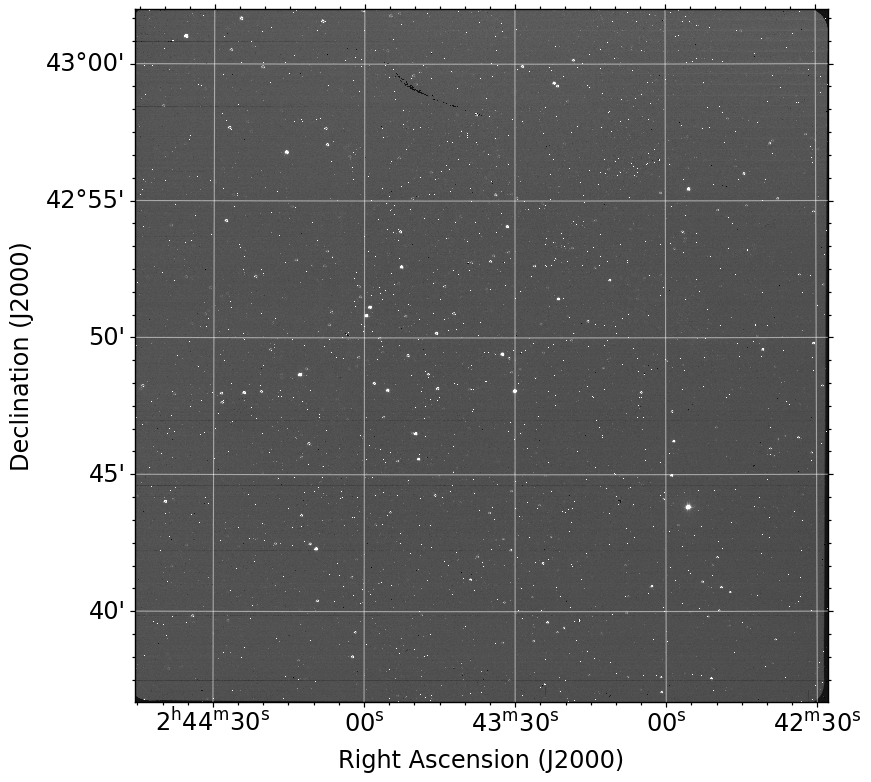

In [34]:
path = os.getcwd()

name = 'M34_0001'
gc = aplpy.FITSFigure(os.path.dirname(path)+f'/output/{name}/{name}_slice_1.fits', north=True, figsize=(9,9))

gc.show_colorscale(cmap='gray')
gc.add_grid()
gc.grid.set_alpha(0.5)
gc.ticks.set_minor_frequency(6)

gc.axis_labels.set_xtext('Right Ascension (J2000)')
gc.axis_labels.set_ytext('Declination (J2000)')
gc.axis_labels.set_font(size='xx-large')
gc.tick_labels.set_font(size='xx-large')